# Methodological Foundation of a Numerical Taxonomy of Urban Form

This notebook serves as a template for morphometric assessment and generation of a taxonomy.

## Reproducible Python code to generate taxonomy

Complete morphometrics assessment from input data to taxonomy.

Input data:
 - building footprints
 - street network
 
This notebook is running the analysis on the sample of the data used in Prague case study. You can replace the sample with your own data, assuming that they are cleaned to a required standard. 

The sample is saved in `../files/sample.gpkg` with two layers named `buildings` and `streets`. `buildings` are Polygons, whilst `streets` are LineStrings.

Buildings data contain a single attribute column:

- `height` - building height in meters.

This notebook has been updated to work with `momepy` 0.5 and `geopandas` 0.10. The original work has been carried out using `momepy` 0.3 within the Docker container `darribas/gds_py:5.0`.

All data generated throughout the method are saved to files (unless commented out).

First we import all required libraries.

In [1]:
import warnings 

import geopandas as gpd
import libpysal
import mapclassify
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from tqdm.auto import tqdm
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy

# we are using bleeding edge software that emits some warnings irrelevant for the current runtime
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
warnings.filterwarnings('ignore', message='.*overflow encountered*')
warnings.filterwarnings('ignore', message='.*index_parts defaults to True')
warnings.filterwarnings('ignore', message='.*`op` parameter is deprecated*')

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check the input data

We load buildings and create unique ID.

In [2]:
# 这是阿姆斯特丹
path = "../files/sample.gpkg"
layer = "buildings"
buildings = gpd.read_file(path, layer=layer)

<AxesSubplot: >

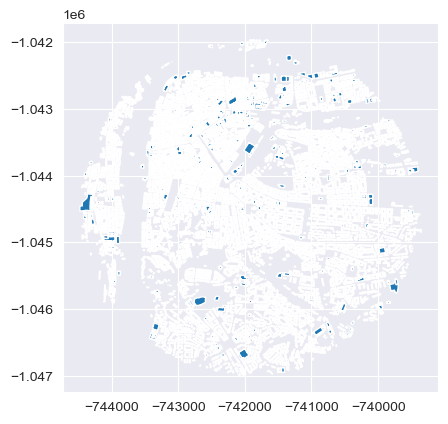

In [3]:
buildings.plot()

In [5]:
# 这是自己的模型
buildings = gpd.read_file('../files/buildings1129.shp')
buildings=buildings.loc[:,['Elevation','材质大','geometry']]
buildings['木']=0
buildings.loc[buildings['材质大']=='木','木']=1
buildings['涂料']=0
buildings.loc[buildings['材质大']=='涂料','涂料']=1
buildings['红砖']=0
buildings.loc[buildings['材质大']=='红砖','红砖']=1
buildings['金属']=0
buildings.loc[buildings['材质大']=='金属','金属']=1
buildings['面砖']=0
buildings.loc[buildings['材质大']=='面砖','面砖']=1
buildings['玻璃']=0
buildings.loc[buildings['材质大']=='玻璃','玻璃']=1
buildings['青砖']=0
buildings.loc[buildings['材质大']=='青砖','青砖']=1
buildings=buildings.drop(['材质大'],axis=1)
buildings=buildings.rename({'Elevation':'height'},axis=1)
buildings

height                                           geometry  木  涂料  红砖  \
0     36.04362  POLYGON ((370400.424 3284751.245, 370396.487 3...  0   1   0   
1     25.01420  POLYGON ((370393.185 3284753.601, 370393.152 3...  0   1   0   
2     24.13479  POLYGON ((370390.849 3284754.973, 370390.748 3...  0   1   0   
3     25.32959  POLYGON ((370207.977 3285052.966, 370215.201 3...  0   0   1   
4     35.85418  POLYGON ((370427.056 3284772.087, 370435.130 3...  0   1   0   
...        ...                                                ... ..  ..  ..   
8758  25.24676  POLYGON ((369802.330 3284938.250, 369802.105 3...  0   1   0   
8759  31.54285  POLYGON ((370046.951 3285133.092, 370039.380 3...  0   0   0   
8760  31.54285  POLYGON ((370039.380 3285133.415, 370037.885 3...  0   0   0   
8761  24.39472  POLYGON ((370158.624 3284713.808, 370157.490 3...  0   1   0   
8762  28.10942  POLYGON ((370157.490 3284713.673, 370156.939 3...  0   1   0   

      金属  面砖  玻璃  青砖  
0      0   0   0   0  
1      0   0   0   0  
2      0   0   0   0  
3      0   0   0   0  
4      0   0   0   0  
...   ..  ..  ..  ..  
8758   0   0   0   0  
8759   0   1   0   0  
8760   1   0   0   0  
8761   0   0   0   0  
8762   0   0   0   0  

[8763 rows x 9 columns]

<AxesSubplot: >

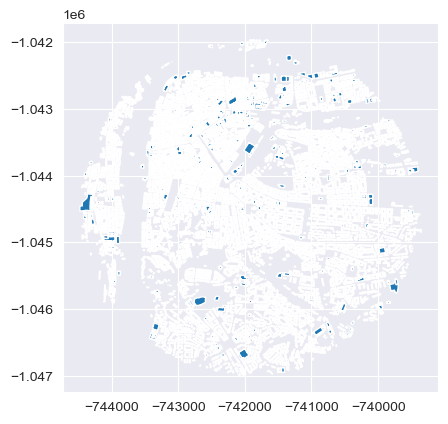

In [4]:
buildings.plot()

Let's create a persistent unique identifier for each building.

In [5]:
buildings["uID"] = range(len(buildings))

### Generate additional morphometric elements

Before we can start morhometrics we have to generate additional elements - tessellation and tessellation based blocks.

#### Morphological tessellation

Check input for tessellation. If the input data is clean, the check will result in zeros. The data does not have to be 100% clean (all 0). For example `Split features` may not cause any issue. 

In [6]:
check = mm.CheckTessellationInput(buildings,shrink=0.1)

Collapsed features  : 0
Split features      : 9
Overlapping features: 0


C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\preprocessing.py:387: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  over_rows = sorted(overlapping.origin.append(overlapping.dest).unique())


Generate tessellation limited to 100 m buffer. Beware, it is memory demanding.

**Note:** You may find that this step requires more memory that you are able to provide. In that case, you may consider using an [enclosed tessellation](http://docs.momepy.org/en/stable/user_guide/elements/enclosed.html) method instead. However, that would require minor adaptation of the code below as well.

In [7]:
limit = mm.buffered_limit(buildings, 10)

tessellation = mm.Tessellation(buildings, "uID", limit, verbose=False,shrink=0.1)
tessellation = tessellation.tessellation

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\elements.py:277: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  objects.loc[mask, objects.geometry.name] = objects[mask].buffer(
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\tools\clip.py:48: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\elements.py:394: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should be edited. unique_id of affected elements: [111, 303, 547, 10

In [8]:
tessellation

uID                                           geometry
1          1  POLYGON ((-742122.355 -1046950.522, -742121.59...
6          6  POLYGON ((-742244.711 -1046935.231, -742244.57...
43        43  POLYGON ((-742433.466 -1046906.789, -742433.75...
100      100  POLYGON ((-742450.484 -1046849.417, -742450.14...
123      123  POLYGON ((-742441.515 -1046822.173, -742441.12...
...      ...                                                ...
12784  12784  POLYGON ((-740624.019 -1042543.489, -740623.73...
12768  12768  POLYGON ((-740587.706 -1042551.940, -740587.75...
12799  12799  POLYGON ((-740530.145 -1042503.145, -740528.97...
12832  12832  POLYGON ((-740646.854 -1042434.135, -740647.07...
12876  12876  POLYGON ((-741700.103 -1042029.751, -741700.29...

[12884 rows x 2 columns]

<AxesSubplot: >

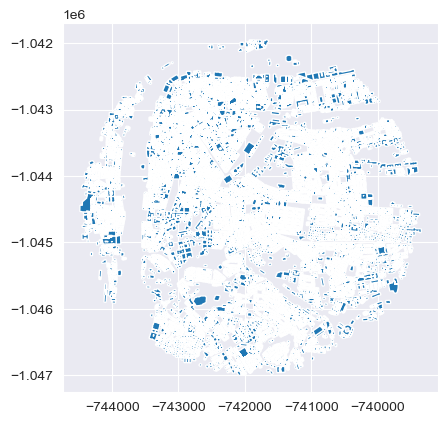

In [9]:
tessellation.plot()

We save tessellation to file. Note that this file is not part of the repository but can be fully created using the input sample and this notebook.

In [10]:
tessellation.to_file("../files/geometry.gpkg", layer="tessellation")

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Tessellation based blocks

To generate tessellation based blocks we also need street network, therefore we need to read it to GeoDataFrame first.

In [13]:
path = "../files/streets.shp"
streets = gpd.read_file(path)
streets=gpd.GeoDataFrame(streets['geometry'])

In [14]:
streets

geometry
0   LINESTRING (369748.161 3284121.735, 369586.261...
1   LINESTRING (370165.482 3285171.342, 370155.930...
2   LINESTRING (368408.136 3284728.424, 369303.340...
3   LINESTRING (370409.997 3285199.176, 370488.402...
4   LINESTRING (370334.225 3285134.783, 370345.756...
..                                                ...
91  LINESTRING (369772.377 3284779.055, 369784.453...
92  LINESTRING (369650.954 3285034.888, 369657.080...
93  LINESTRING (369988.226 3285150.391, 369986.667...
94  LINESTRING (369817.604 3285323.260, 369886.863...
95  LINESTRING (369847.084 3284980.279, 369857.695...

[96 rows x 1 columns]

<AxesSubplot: >

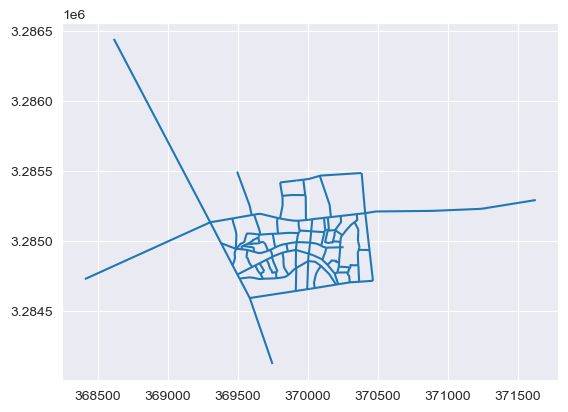

In [15]:
streets.plot()

To create blocks within the full `limit`, it is always safer to extend street network to the edge of the limit.

In [16]:
extended = mm.extend_lines(streets, tolerance=120, target=gpd.GeoSeries([limit.boundary]), barrier=buildings)

In [17]:
blocks = mm.Blocks(tessellation, edges=extended, buildings=buildings, id_name='bID', unique_id='uID')
blocks_df = blocks.blocks  # get blocks df
buildings['bID'] = blocks.buildings_id.values  # get block ID
tessellation['bID'] = blocks.tessellation_id.values  # get block ID

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\elements.py:631: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4509
Right CRS: None

  cut = gpd.overlay(
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\libpysal\weights\_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy)) for shape in shape)))


#### Link streets

We need to understand which building belongs to which street segment. We link IDs together based on proximity.

In [18]:
streets["nID"] = range(len(streets))
buildings['nID'] = mm.get_network_id(buildings, streets, 'nID', min_size=300, verbose=False)
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

Finally, we save elements to a file.

In [19]:
path = '../files/geometry.gpkg'
tessellation.to_file(path, layer='tessellation', driver='GPKG')
buildings.to_file(path, layer='buildings', driver='GPKG')
blocks_df.to_file(path, layer='blocks', driver='GPKG')

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Measure primary characters

This part measures 74 primary morphometric characters.

It does save intermediate parquet files as a backup.

In [20]:
blocks = blocks_df

Note: 

- `height` is building height in meters. If you do not have it, skip affected lines.

In [21]:
buildings['floor_area'] = (buildings["height"] / 3.5) * buildings.area

In [22]:
buildings['sdbAre'] = mm.Area(buildings).series
buildings['sdbVol'] = mm.Volume(buildings, 'height', 'sdbAre').series
buildings['sdbPer'] = mm.Perimeter(buildings).series
buildings['sdbCoA'] = mm.CourtyardArea(buildings, 'sdbAre').series

buildings['ssbFoF'] = mm.FormFactor(buildings, 'sdbVol', 'sdbAre').series
buildings['ssbVFR'] = mm.VolumeFacadeRatio(buildings, 'height', 'sdbVol', 'sdbPer').series
buildings['ssbCCo'] = mm.CircularCompactness(buildings, 'sdbAre').series
buildings['ssbCor'] = mm.Corners(buildings, verbose=False).series
buildings['ssbSqu'] = mm.Squareness(buildings, verbose=False).series
buildings['ssbERI'] = mm.EquivalentRectangularIndex(buildings, 'sdbAre', 'sdbPer').series
buildings['ssbElo'] = mm.Elongation(buildings).series

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\shape.py:795: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\shape.py:919: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(cosine_angle))


In [23]:
cencon = mm.CentroidCorners(buildings, verbose=False)
buildings['ssbCCM'] = cencon.mean
buildings['ssbCCD'] = cencon.std

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\shape.py:1147: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


In [24]:
buildings['stbOri'] = mm.Orientation(buildings, verbose=False).series
 
tessellation['stcOri'] = mm.Orientation(tessellation, verbose=False).series
buildings['stbCeA'] = mm.CellAlignment(buildings, tessellation, 'stbOri', 'stcOri', 'uID', 'uID').series

In [25]:
tessellation['sdcLAL'] = mm.LongestAxisLength(tessellation).series
tessellation['sdcAre'] = mm.Area(tessellation).series
tessellation['sscCCo'] = mm.CircularCompactness(tessellation, 'sdcAre').series
tessellation['sscERI'] = mm.EquivalentRectangularIndex(tessellation, 'sdcAre').series

In [26]:
buildings["mtbSWR"] = mm.SharedWallsRatio(buildings, "sdbPer").series
 
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)
 
buildings["mtbAli"] = mm.Alignment(buildings, queen_1, "uID", "stbOri", verbose=False).series
buildings["mtbNDi"] = mm.NeighborDistance(buildings, queen_1, "uID", verbose=False).series
tessellation["mtcWNe"] = mm.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["mdcAre"] = mm.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\libpysal\weights\_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy)) for shape in shape)))
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\libpysal\weights\_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\distribution.py:491: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  data.iteritems(), total=data.shape[0], disable=not verbose
C:\Users\YAGA\anac

In [27]:
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
 
buildings["libNCo"] = mm.Courtyards(buildings, spatial_weights=buildings_q1, verbose=False).series
buildings["ldbPWL"] = mm.PerimeterWall(buildings, buildings_q1, verbose=False).series
 
blocks["ldkAre"] = mm.Area(blocks).series
blocks["ldkPer"] = mm.Perimeter(blocks).series
blocks["lskCCo"] = mm.CircularCompactness(blocks, "ldkAre").series
blocks["lskERI"] = mm.EquivalentRectangularIndex(blocks, "ldkAre", "ldkPer").series
blocks["lskCWA"] = mm.CompactnessWeightedAxis(blocks, "ldkAre", "ldkPer").series
blocks["ltkOri"] = mm.Orientation(blocks, verbose=False).series
 
blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blocks, ids="bID", silence_warnings=True)
 
blocks["ltkWNB"] = mm.Neighbors(blocks, blo_q1, "bID", weighted=True, verbose=False).series
blocks["likWBB"] = mm.Count(blocks, buildings, "bID", "bID", weighted=True).series

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\distribution.py:905: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  gdf.set_index(unique_id).geometry.iteritems(),


Save data to parquets as a checkpoint backup.

In [28]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
blocks.drop(columns='geometry').to_parquet('../files/blocks_data.parquet')

In [29]:
queen_3 = mm.sw_high(k=3, weights=queen_1)

buildings['ltbIBD'] = mm.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['ltcBuA'] = mm.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

In [30]:
tessellation = tessellation.merge(buildings[['floor_area', 'uID']], on='uID', how='left')
tessellation['licGDe'] = mm.Density(tessellation, 'floor_area', queen_3, 'uID', 'sdcAre').series
tessellation = tessellation.drop(columns='floor_area')
tessellation['ltcWRB'] = mm.BlocksCount(tessellation, 'bID', queen_3, 'uID', verbose=False).series
tessellation['sicCAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'sdbAre', 'uID').series
tessellation['sicFAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'floor_area', 'uID').series

100%|██████████| 8755/8755 [00:07<00:00, 1242.17it/s]


Save data to parquets and spatial weights matrices to gal files.

In [31]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
 
fo = libpysal.io.open('../files/queen_1.gal', 'w')
fo.write(queen_1)
fo.close()
 
fo = libpysal.io.open('../files/queen_3.gal', 'w')
fo.write(queen_3)
fo.close()
 
fo = libpysal.io.open('../files/buildings_q1.gal', 'w')
fo.write(buildings_q1)
fo.close()

In [32]:
streets["sdsLen"] = mm.Perimeter(streets).series
tessellation["stcSAl"] = mm.StreetAlignment(tessellation, streets, "stcOri", "nID").series
buildings["stbSAl"] = mm.StreetAlignment(buildings, streets, "stbOri", "nID").series

In [1]:
profile = mm.StreetProfile(streets, buildings, heights='height', distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPH"] = profile.h
streets["sdsSPR"] = profile.p
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd
streets["sdsSHD"] = profile.hd

NameError: name 'mm' is not defined

In [34]:
streets["sssLin"] = mm.Linearity(streets).series
streets["sdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", mode="sum", values="sdcAre").series
streets["sisBpM"] = mm.Count(streets, buildings, "nID", "nID", weighted=True).series

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\intensity.py:478: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  left[left_id].iteritems(), total=left.shape[0], disable=not verbose
100%|██████████| 96/96 [00:00<00:00, 1411.59it/s]


In [35]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
streets.drop(columns='geometry').to_parquet('../files/streets_data.parquet')

In [36]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)
 
streets["misRea"] = mm.Reached(
    streets, tessellation, "nID", "nID", spatial_weights=str_q1, mode="count", verbose=False
).series
streets["mdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", spatial_weights=str_q1,
                               mode="sum", verbose=False).series

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\intensity.py:478: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  left[left_id].iteritems(), total=left.shape[0], disable=not verbose
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\intensity.py:478: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  left[left_id].iteritems(), total=left.shape[0], disable=not verbose


In [37]:
graph = mm.gdf_to_nx(streets)
graph = mm.node_degree(graph)
graph = mm.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len", 
    verbose=False
)
graph = mm.cds_length(graph, radius=3, name="ldsCDL", verbose=False)
graph = mm.clustering(graph, name="xcnSCl")
graph = mm.mean_node_dist(graph, name="mtdMDi", verbose=False)
 
nodes, edges, sw = mm.nx_to_gdf(graph, spatial_weights=True)

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 39 disconnected components.
  warnings.warn(message)


In [38]:
nodes.to_file(path, layer="nodes", driver="GPKG")
edges.to_file(path, layer="edges", driver="GPKG")
 
fo = libpysal.io.open("../files/nodes.gal", "w")
fo.write(sw)
fo.close()

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [39]:
edges_w3 = mm.sw_high(k=3, gdf=edges)
edges["ldsMSL"] = mm.SegmentsLength(edges, spatial_weights=edges_w3, mean=True, verbose=False).series
 
edges["ldsRea"] = mm.Reached(edges, tessellation, "nID", "nID", spatial_weights=edges_w3, verbose=False).series
edges["ldsRea"] = mm.Reached(
    edges, tessellation, "nID", "nID", spatial_weights=edges_w3, mode="sum", values="sdcAre", verbose=False
).series
 
nodes_w5 = mm.sw_high(k=5, weights=sw)
nodes["lddNDe"] = mm.NodeDensity(nodes, edges, nodes_w5, verbose=False).series
nodes["linWID"] = mm.NodeDensity(
    nodes, edges, nodes_w5, weighted=True, node_degree="degree", verbose=False
).series
 
buildings["nodeID"] = mm.get_node_id(buildings, nodes, edges, "nodeID", "nID")
tessellation = tessellation.merge(buildings[["uID", "nodeID"]], on="uID", how="left")
 
nodes_w3 = mm.sw_high(k=3, weights=sw)
 
nodes["lddRea"] = mm.Reached(nodes, tessellation, "nodeID", "nodeID", nodes_w3, verbose=False).series
nodes["lddARe"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", nodes_w3, mode="sum", values="sdcAre", verbose=False
).series
 
nodes["sddAre"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", mode="sum", values="sdcAre", verbose=False
).series
nodes["midRea"] = mm.Reached(nodes, tessellation, "nodeID", "nodeID", spatial_weights=sw, verbose=False).series
nodes["midAre"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", spatial_weights=sw, mode="sum", values="sdcAre", verbose=False
).series
 
nodes.rename(
    columns={
        "degree": "mtdDeg",
        "meshedness": "lcdMes",
        "local_closeness": "lcnClo",
        "proportion_3": "linP3W",
        "proportion_4": "linP4W",
        "proportion_0": "linPDE",
    }, inplace=True
)

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\intensity.py:478: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  left[left_id].iteritems(), total=left.shape[0], disable=not verbose
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\intensity.py:478: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  left[left_id].iteritems(), total=left.shape[0], disable=not verbose
100%|██████████| 8763/8763 [00:02<00:00, 3688.67it/s]
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\intensity.py:478: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  left[left_id].iteritems(), total=left.shape[0], disable=not verbose
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\intensity.py:478: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  left[left_

In [40]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
nodes.drop(columns='geometry').to_parquet('../files/nodes_data.parquet')
edges.drop(columns='geometry').to_parquet('../files/edges_data.parquet')

In [41]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'bID', 'nodeID', 'geometry']), on='uID')
merged = merged.merge(blocks.drop(columns='geometry'), on='bID', how='left')
merged = merged.merge(edges.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

Clean columns to keep only measured data.

In [42]:
primary = merged.drop(columns=['nID', 'bID', 'nodeID', 'mm_len', 'cdsbool', 
                               'node_start', 'node_end', 'geometry', 'floor_area'
                               ])

In [43]:
primary.to_parquet('../files/primary.parquet')

## Measure contextual - spatially lagged characters

This part measures contextual characters.

In [44]:
gdf = primary.set_index('uID')
gdf2=gdf.loc[:,['木','涂料','红砖','金属','面砖','玻璃','青砖']]
gdf=gdf.drop(['木','涂料','红砖','金属','面砖','玻璃','青砖'],axis=1)
spatial_weights = queen_3
unique_id = 'uID'

In [45]:
means = {}
means2={}
ranges = {}
theils = {}
simpsons = {}

for ch in gdf.columns:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []
    simpsons[ch] = []
for ch in gdf2.columns:
    means2[ch]=[]

Resolve potential missingness cause by invalid input data. That was not case in the presented case studies but may be case in subsequent research.

In [46]:
gdf = gdf.replace(np.inf, np.nan).fillna(0)  # normally does not happen, but to be sure
chars = gdf.columns
chars2=gdf2.columns


In [47]:
gdf['lcdMes'] = gdf.apply(
            lambda row: row.lcdMes if row.lcdMes >= 0 else 0,
            axis=1,
        )  # normally does not happen, but to be sure

Define Theil and Simpson functions.

In [48]:
def _theil(y):
    y = np.array(y)
    n = len(y)
    plus = y + np.finfo('float').tiny * (y == 0)  # can't have 0 values
    yt = plus.sum(axis=0)
    s = plus / (yt * 1.0)
    lns = np.log(n * s)
    slns = s * lns
    t = sum(slns)
    return t

In [49]:
def _simpson_di(data):

    def p(n, N):
        if n == 0:
            return 0
        return float(n) / N

    N = sum(data.values())

    return sum(p(n, N) ** 2 for n in data.values() if n != 0)

Skewness is used as an estimation of the distribution. Extremely skewed use HeadTail breaks for Simpson's binning, other Natural Breaks.

In [50]:
skewness = pd.DataFrame(index=chars)
for c in chars:
    skewness.loc[c, 'skewness'] = sp.stats.skew(gdf[c])
headtail = list(skewness.loc[skewness.skewness >= 1].index)
to_invert = skewness.loc[skewness.skewness <= -1].index

for inv in to_invert:
    gdf[inv + '_r'] = gdf[inv].max() - gdf[inv]
inverted = [x for x in gdf.columns if '_r' in x]
headtail = headtail + inverted
natural = [x for x in chars if x not in headtail]

In [51]:
bins = {}
for c in headtail:
    bins[c] = mapclassify.HeadTailBreaks(gdf[c]).bins
for c in natural:
    bins[c] = mapclassify.gadf(gdf[c], method='NaturalBreaks')[1].bins

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\mapclassify\classifiers.py:1718: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(ms, UserWarning)
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\mapclassify\classifiers.py:1719: UserWarning: Warning: setting k to 1
  Warn("Warning: setting k to %d" % uvk, UserWarning)
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\mapclassify\classifiers.py:2660: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - cl.adcm / adam
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\mapclassify\classifiers.py:1718: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(ms, UserWarning)
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\mapclassify\classifiers.py:1719: Us

Loop over DataFrame and measure IQM, IQR, IDT and Simpson.

In [52]:
print(type(spatial_weights.neighbors))
print(spatial_weights.neighbors.keys())

<class 'dict'>
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,

In [53]:
# 因为有些buildings丢失了，所以只能在现在存在的buildings索引上跑一遍
index_list=list(gdf.index.values)
for index in tqdm(index_list, total=gdf.shape[0]):
    neighbours = [index]
    neighbours += spatial_weights.neighbors[index]  
    subset = gdf.loc[neighbours]
    subset2=gdf2.loc[neighbours]
    for ch in chars:
        values_list = subset[ch] 
        idec = mm.limit_range(values_list, rng=(10, 90))
        iquar = mm.limit_range(values_list, rng=(25, 75))
        
        means[ch].append(np.mean(iquar))
        ranges[ch].append(max(iquar) - min(iquar))
        theils[ch].append(_theil(idec))
        
        sample_bins = mapclassify.UserDefined(values_list, list(bins[ch]))
        counts = dict(zip(bins[ch], sample_bins.counts))
        simpsons[ch].append(_simpson_di(counts))
    for ch in chars2:
        values_list = subset2[ch]
        means2[ch].append(np.mean(values_list))

  0%|          | 0/8755 [00:00<?, ?it/s]C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
  0%|          | 3/8755 [00:00<06:42, 21.74it/s]C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
C:\Users\YAGA\anaconda

In [54]:
contextual = {}
for ch in chars:
    contextual[ch + '_meanIQ3'] = means[ch]
    contextual[ch + '_rangeIQ3'] = ranges[ch]
    contextual[ch + '_theilID3'] = theils[ch]
    contextual[ch + '_simpson'] = simpsons[ch]
for ch in chars2:
    contextual[ch + '_means'] = means2[ch]

contextual = pd.DataFrame(contextual, index=gdf.index)

In [55]:
contextual.shape
contextual

stcOri_meanIQ3  stcOri_rangeIQ3  stcOri_theilID3  stcOri_simpson  \
uID                                                                      
7271        4.136175         3.920438         0.123905        0.517578   
7270        5.511106         4.350367         0.066529        0.512465   
7307        6.575054         3.768667         0.035739        0.496599   
7319        7.378260         2.594505         0.054825        0.519849   
2320        7.194079         2.779551         0.032216        0.494810   
...              ...              ...              ...             ...   
8210        6.279579        13.431259         0.422901        0.289307   
8388        4.326046         6.808198         0.262049        0.412098   
8638        3.228482         5.808201         0.340501        0.452728   
8211        3.849702         6.254226         0.493573        0.368512   
8295        9.829294         3.273151         0.013926        0.500000   

      sdcLAL_meanIQ3  sdcLAL_rangeIQ3  sdcLAL_theilID3  sdcLAL_simpson  \
uID                                                                      
7271       15.001748         3.771138         0.010492        0.521484   
7270       15.745526         4.519084         0.010040        0.523546   
7307       15.054856         6.916330         0.029134        0.365079   
7319       16.226666         7.638786         0.043513        0.345936   
2320       13.710495         7.691219         0.054592        0.346405   
...              ...              ...              ...             ...   
8210       13.531563        17.195647         0.242918        0.288199   
8388       15.108737        14.418723         0.093509        0.265595   
8638       16.926384        13.565743         0.092009        0.239484   
8211       14.287125        15.413837         0.176122        0.276384   
8295       35.630397         2.957542         0.000862        1.000000   

      sdcAre_meanIQ3  sdcAre_rangeIQ3  ...  midAre_rangeIQ3  midAre_theilID3  \
uID                                    ...                                     
7271       81.150768        72.302964  ...         0.000000    -2.220446e-16   
7270       97.053378        96.624573  ...         0.000000    -2.220446e-16   
7307       86.695512       100.953242  ...         0.000000     9.255904e-02   
7319      105.900895       100.836162  ...     18366.788657     1.065360e-01   
2320       68.210578       102.804868  ...     18366.788657     1.065360e-01   
...              ...              ...  ...              ...              ...   
8210       66.888163       141.020317  ...     11942.936127     1.030584e-01   
8388       89.446856       145.838066  ...         0.000000     0.000000e+00   
8638      102.342085       143.438703  ...         0.000000     5.047826e-02   
8211       77.820778       137.205398  ...     11942.936127     9.226647e-02   
8295      626.762532       199.636822  ...         0.000000     0.000000e+00   

      midAre_simpson  木_means  涂料_means  红砖_means  金属_means  面砖_means  \
uID                                                                     
7271        0.939453      0.0  0.718750  0.093750       0.0  0.125000   
7270        1.000000      0.0  0.684211  0.157895       0.0  0.052632   
7307        0.654195      0.0  0.380952  0.261905       0.0  0.309524   
7319        0.523629      0.0  0.130435  0.260870       0.0  0.521739   
2320        0.435602      0.0  0.333333  0.333333       0.0  0.294118   
...              ...      ...       ...       ...       ...       ...   
8210        0.520000      0.0  0.505263  0.378947       0.0  0.000000   
8388        0.841210      0.0  0.195652  0.652174       0.0  0.086957   
8638        0.700125      0.0  0.306122  0.469388       0.0  0.061224   
8211        0.543253      0.0  0.411765  0.411765       0.0  0.014706   
8295        1.000000      0.0  0.000000  1.000000       0.0  0.000000   

      玻璃_means  青砖_means  
uID                       
7271       0.0  0.062500  
7270    

In [56]:
contextual.to_parquet('../files/contextual.parquet')

## Clustering

We use contextual characters to do GMM clustering.

In [57]:
data = contextual.copy()

First we standardize data.

In [58]:
# normalise data

x = data.values
scaler = preprocessing.StandardScaler()
cols = list(data.columns)
data[cols] = scaler.fit_transform(data[cols])

Measure BIC to estimate optimal number of clusters.

In [59]:
bic = pd.DataFrame(columns=['n', 'bic', 'run'])
ix = 0
n_components_range = range(2,10) # specify range you want to assess. 2-8 is sensible for the sample, not the whole city
gmmruns = 5  # specify how many times should each option be tried (more better, but takes a long time)

In [60]:
data = data.fillna(0)
for n_components in n_components_range:
    for i in range(gmmruns):
        gmm = GaussianMixture(n_components=n_components, covariance_type="full", max_iter=200, n_init=1, verbose=1)
        fitted = gmm.fit(data)
        bicnum = gmm.bic(data)
        bic.loc[ix] = [n_components, bicnum, i]
        ix += 1
        print(n_components, i, "BIC:", bicnum)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
2 0 BIC: 1287407.8914908795
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
2 1 BIC: 1285217.5658229021
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
2 2 BIC: 1287407.8914908795
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
2 3 BIC: 1287407.8914908795
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
2 4 BIC: 1285548.6050153594
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
3 0 BIC: 793806.5550527293
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
3 1 BIC: 793806.5550527293
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
3 2 BIC: 793814.9914986356
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
3 3 BIC: 896797.2825628088
Initialization 0
  I

In [61]:
bic.to_csv('../files/complete_BIC_new.csv')

Based on the plot below, we estimate the optimal `n` either based on the elbow of the curve or as the minimum.

<AxesSubplot: xlabel='n', ylabel='bic'>

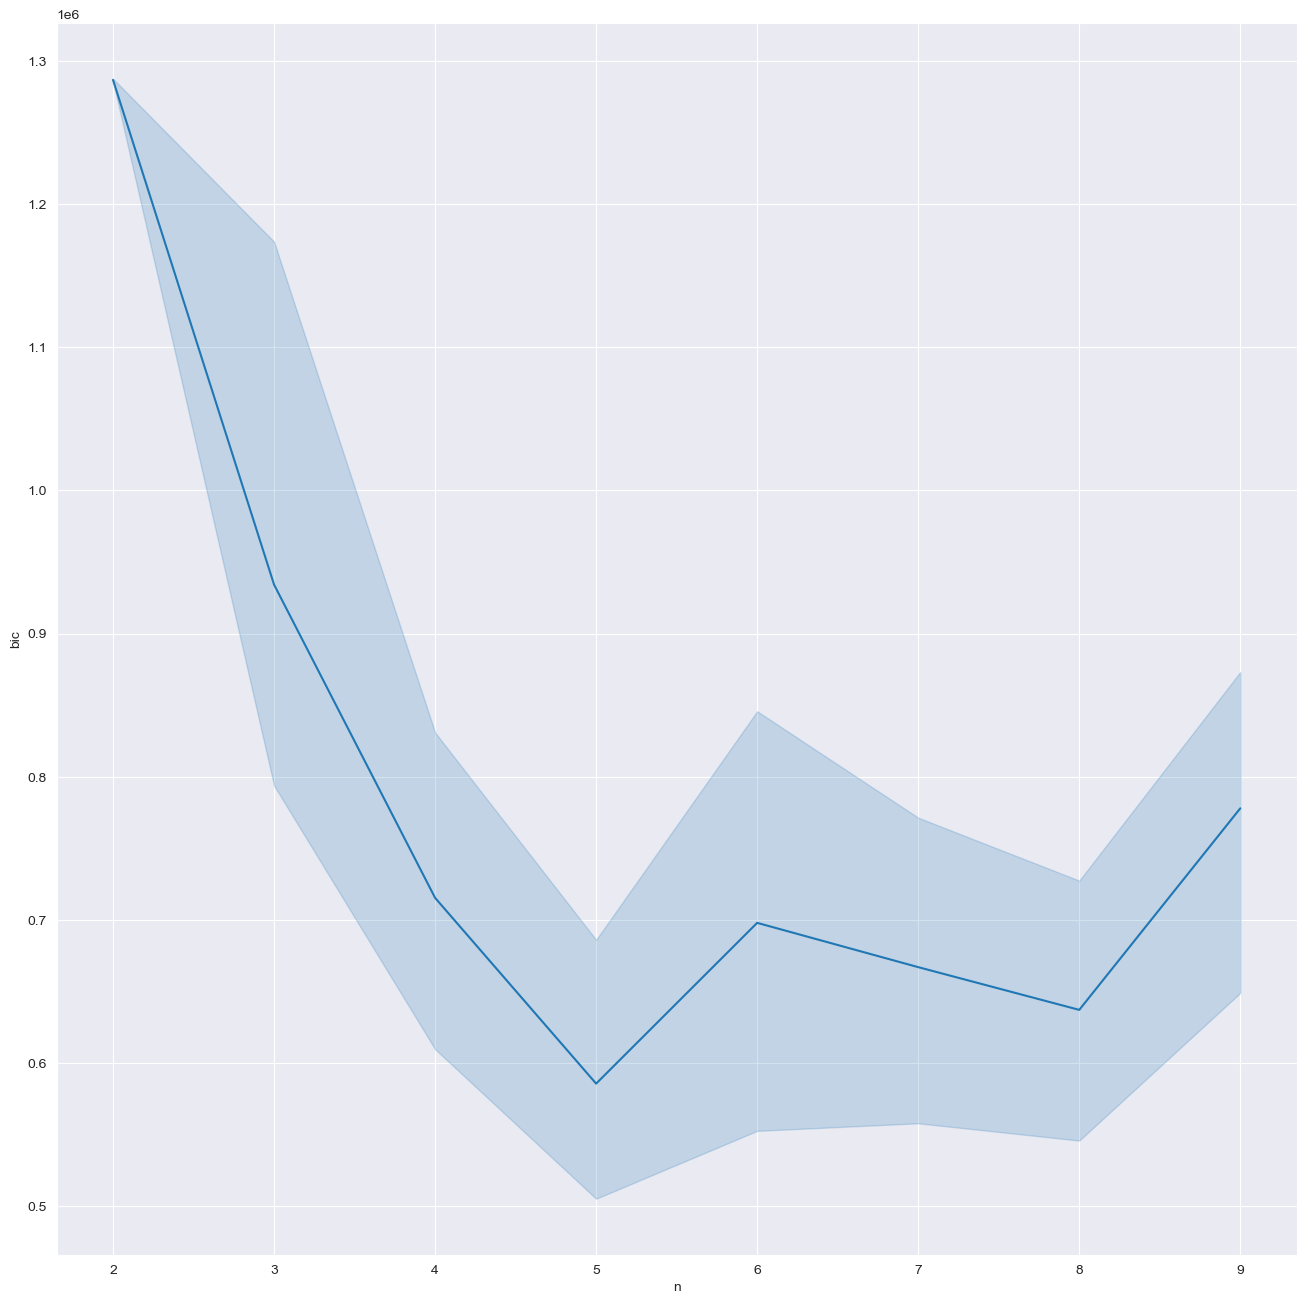

In [62]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.lineplot(ax=ax, x='n', y='bic', data=bic)
# plt.savefig('../files/complete_BIC.pdf')

### Gaussian Mixture Model

In [63]:
n1 = 6  # illustrative - always base the number on a reasonable estimation of the optimal number of components
n_init1 = 5  # more initialization, more stable clustering gets

n2 = 5  # illustrative - always base the number on a reasonable estimation of the optimal number of components
n_init2 = 5  # more initialization, more stable clustering gets

# 分6类
gmm1 = GaussianMixture(n_components=n1, covariance_type="full", max_iter=200, n_init=n_init1, verbose=1)
# 分5类
gmm2 = GaussianMixture(n_components=n2, covariance_type="full", max_iter=200, n_init=n_init2, verbose=1)

fitted1 = gmm1.fit(data)
fitted2 = gmm2.fit(data)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 1
  Iteration 10
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 3
  Iteration 10
Initialization converged: True
Initialization 4
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Initialization converged: True
Initialization 2
  Iteration 10
Initialization converged: True
Initialization 3
  Iteration 10
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
Initialization converged: True


In [64]:
labels1 = gmm1.predict(data)
labels2 = gmm2.predict(data)

In [65]:
pd.Series(labels1, index=data.index).to_csv('../files/cluster_labels1_new.csv')
pd.Series(labels2, index=data.index).to_csv('../files/cluster_labels2_new.csv')

#### Hierachical clustering

Finally, we create hierarchical classification - taxonomy.

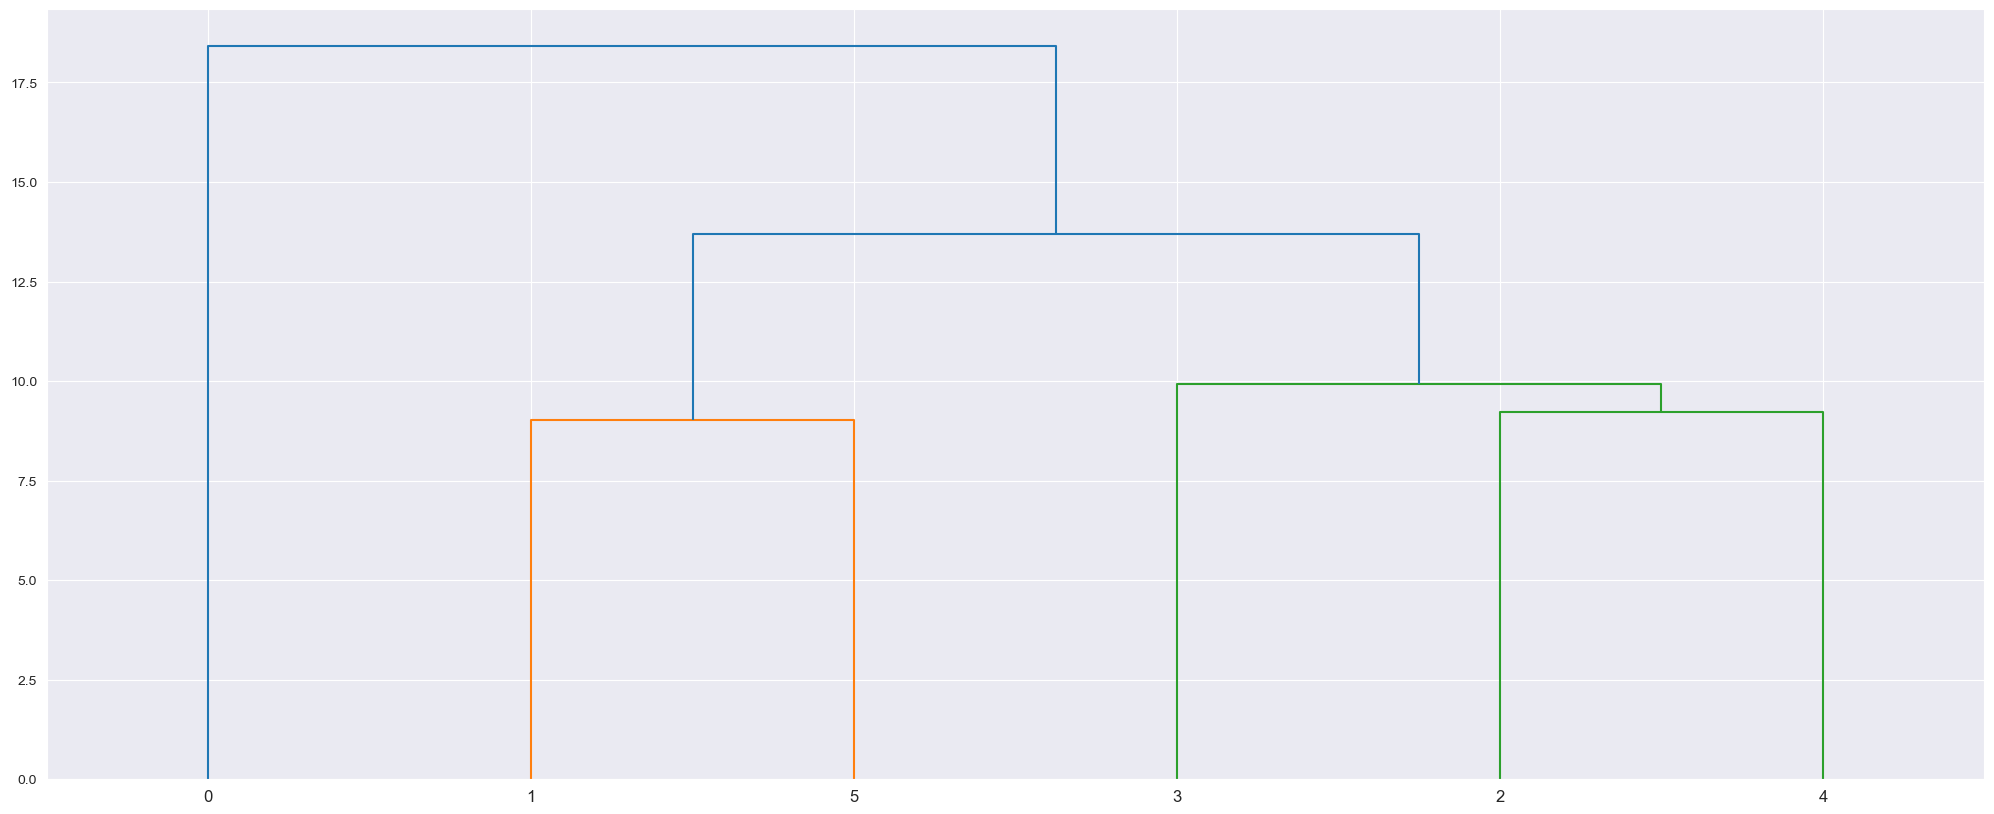

In [66]:
# 分6类
group = data.groupby(labels1).mean()
Z = hierarchy.linkage(group, 'ward')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, labels=group.index)

# plt.savefig('tree.pdf')

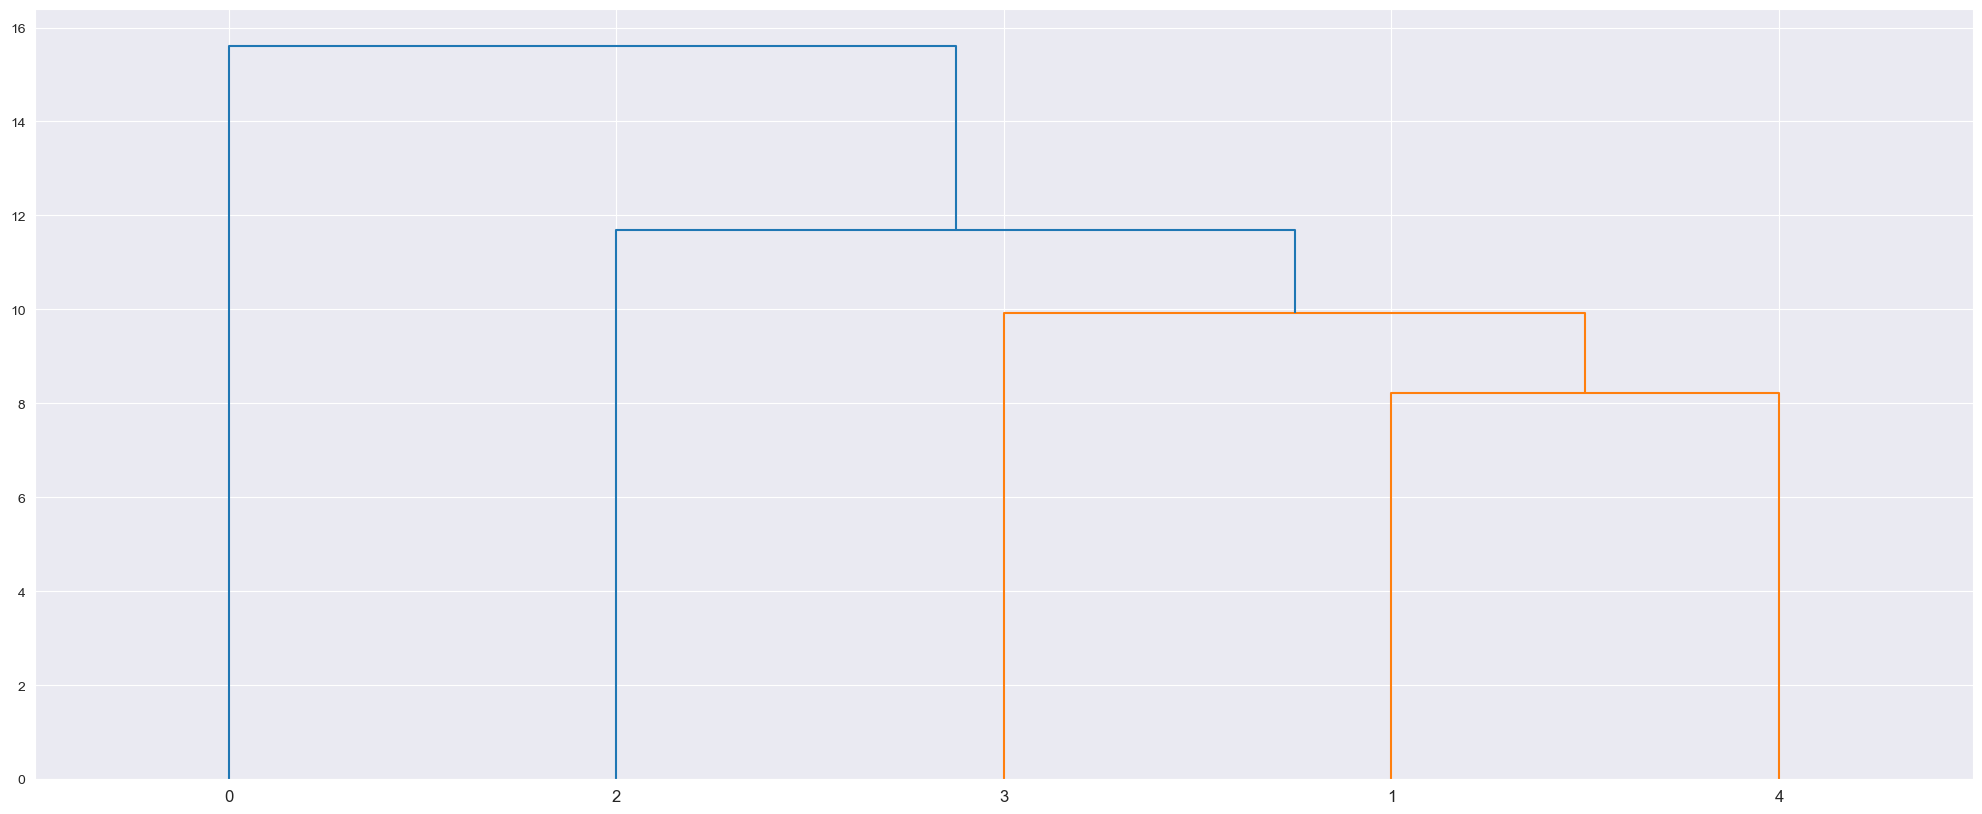

In [67]:
# 分5类
group = data.groupby(labels2).mean()
Z = hierarchy.linkage(group, 'ward')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, labels=group.index)

# plt.savefig('tree.pdf')

## Results

<AxesSubplot: >

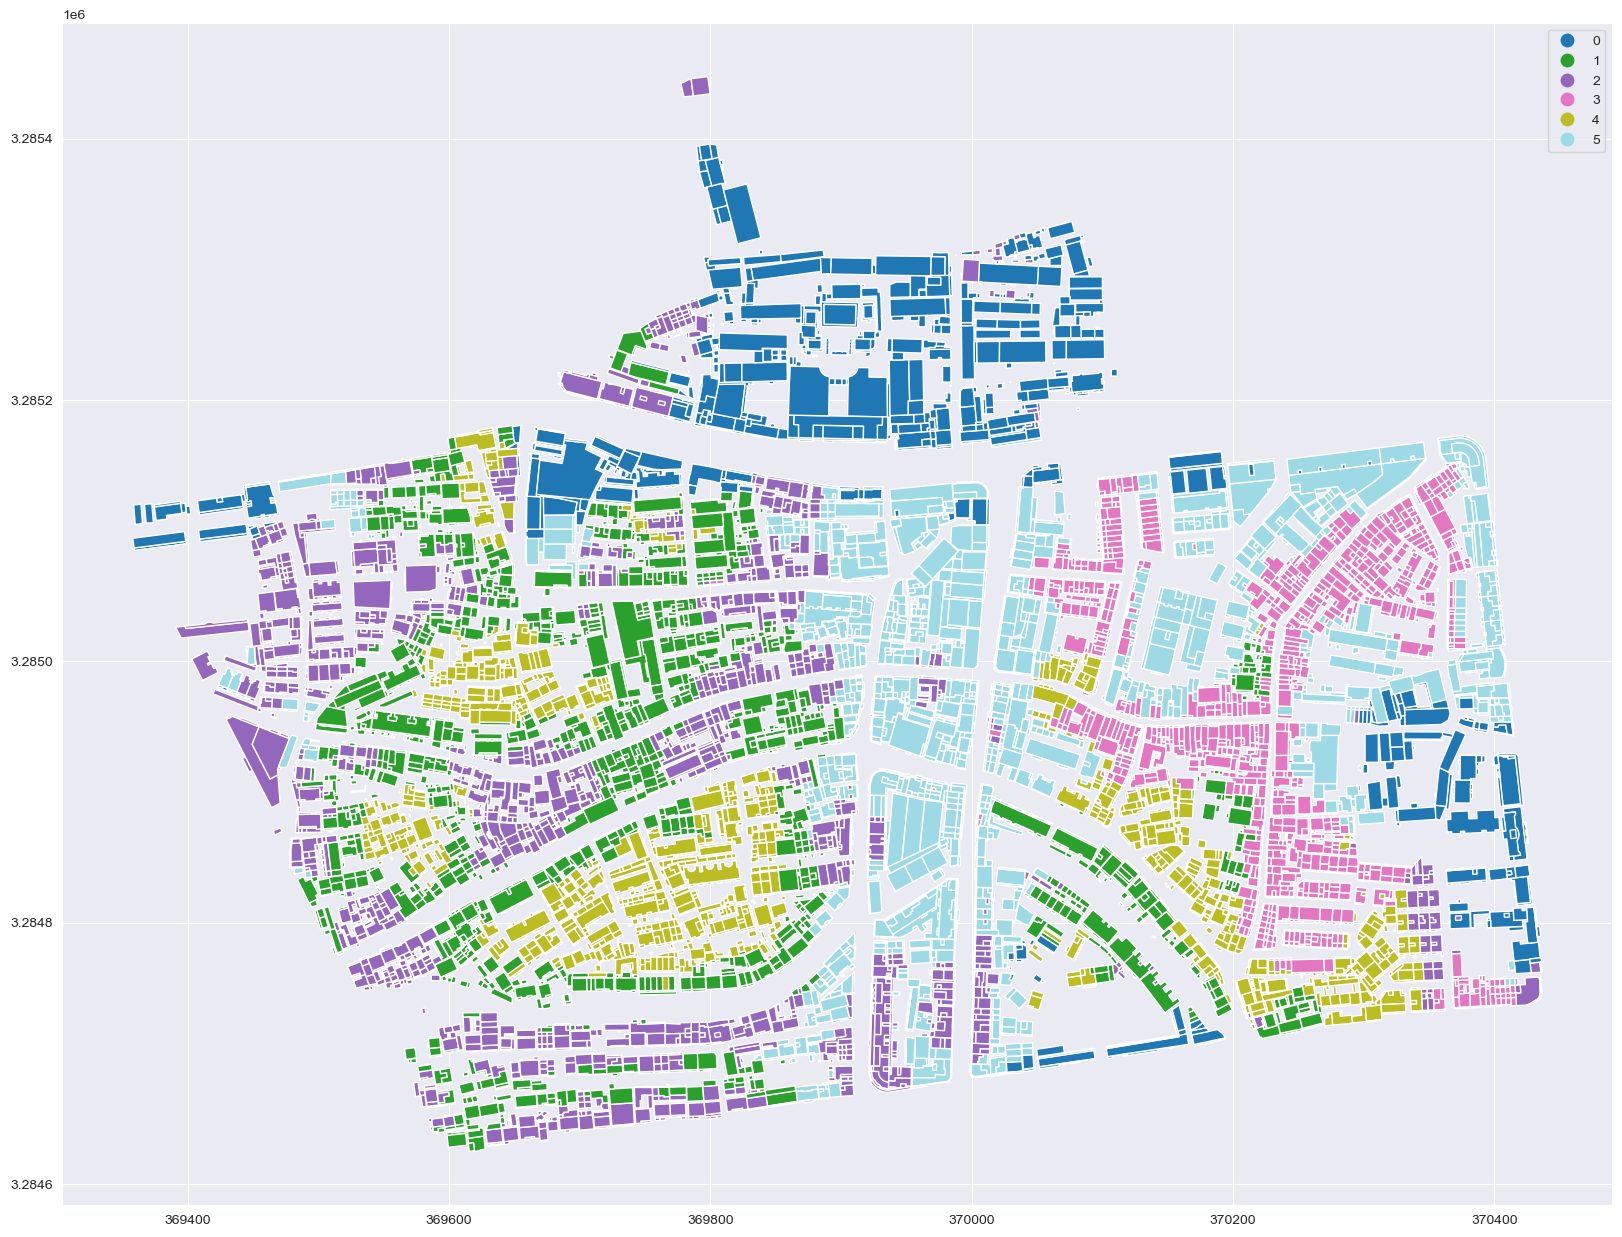

In [68]:
# 分6类

buildings.loc[index_list].plot(labels1, categorical=True, cmap='tab20', legend=True, figsize=(20, 20))


<AxesSubplot: >

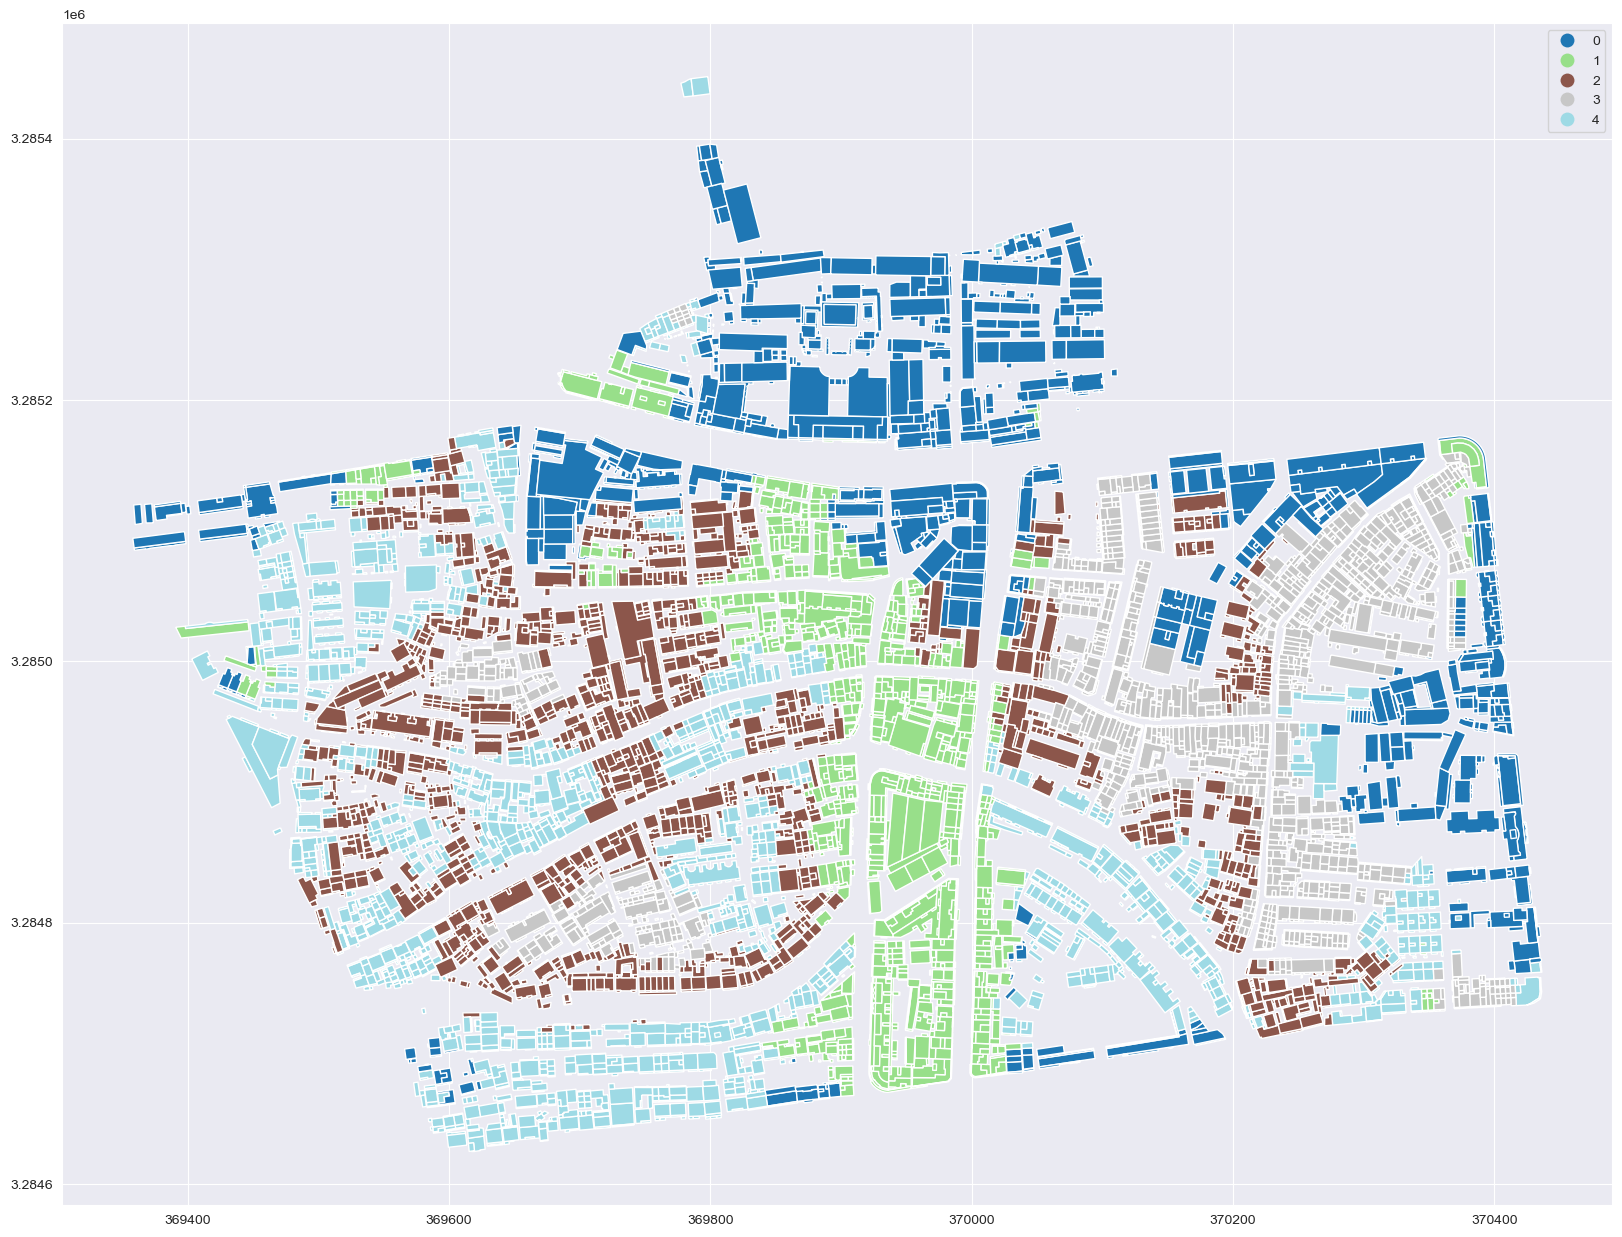

In [69]:
# 分5类
buildings.loc[index_list].plot(labels2, categorical=True, cmap='tab20', legend=True, figsize=(20, 20))

In [70]:
labels1

array([2, 2, 2, ..., 0, 0, 2], dtype=int64)

In [77]:
labels1_old=pd.read_csv('../files/cluster_labels1.csv',index_col='uID')
labels1_old.columns=['labels_old']
labels1_old

labels_old
uID             
7271           4
7270           0
7307           0
7319           0
2320           0
...          ...
8210           0
8395           0
8211           0
8638           0
8295           0

[8755 rows x 1 columns]

In [79]:
labels1_new=pd.read_csv('../files/cluster_labels1_new.csv',index_col='uID')
labels1_new.columns=['labels_new']
labels_diff=pd.merge(labels1_new,labels1_old,on='uID')


labels_new  labels_old
uID                         
7271           2           4
7270           2           0
7307           2           0
7319           5           0
2320           1           0
...          ...         ...
8210           0           0
8388           0           0
8638           0           0
8211           0           0
8295           2           0

[8755 rows x 2 columns]

In [84]:
labels_diff.loc[labels_diff['labels_old']==0,'labels_temp']=4
labels_diff.loc[labels_diff['labels_old']==1,'labels_temp']=4
labels_diff.loc[labels_diff['labels_old']==2,'labels_temp']=4
labels_diff.loc[labels_diff['labels_old']==3,'labels_temp']=4
labels_diff.loc[labels_diff['labels_old']==4,'labels_temp']=4
labels_diff

C:\Program Files\JetBrains\PyCharm 2022.1.3\plugins\python\helpers\pydev\_pydevd_bundle\pydevd_xml.py:375: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  xml_shape = ' shape="%s"' % make_valid_xml_value("%s" % str(len(v)))
C:\Program Files\JetBrains\PyCharm 2022.1.3\plugins\python\helpers\pydev\_pydevd_bundle\pydevd_utils.py:605: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  s = s[:max_items]
C:\Program Files\JetBrains\PyCharm 2022.1.3\plugins\python\helpers\pydev\_pydevd_bundle\pydevd_utils.py:606: FutureWarning: iteritems is deprecated and will be removed in a futu

KeyboardInterrupt: 